# <center> Convolutional Neural Network (CNN) on MNIST dataset

In this below notebook, we will learn the different aspects of CNN by working on MNIST dataset which is used to recognise hand written numeric digits.

* Here I used 3 different architectures and compared their performance at the end.

* We didn't used transfer learning from any other models like VGG-16 or Inception Net etc, just to learn bulding a CNN from scratch.

* Used dropouts and batch normalization layers in all the architectures to avoid overfitting and to improve performance of the model.

In [1]:
import keras
import pandas as pd
import numpy as np
import seaborn as sns
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from keras.initializers import glorot_normal
from keras.initializers import he_normal
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
batch_size = 256
num_op_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

### Utility functions:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def plotter(x, v, t):
    '''
    To plot Train and Validation loss VS Epochs
    '''
    plt.figure(figsize=(9,5))
    plt.plot(x, v, 'b', label="Validation Loss")
    plt.plot(x, t, 'r', label="Train Loss")
    plt.xlabel('Epochs',fontsize=13)
    plt.ylabel('Train & Valdation loss',fontsize=13)
    plt.title('Epoch vs Train & Validation loss ',fontsize=15)
    plt.legend()
    plt.show()

In [0]:
def best_hyperparameter(model,df):
  '''
  To print score from hyper parameter settings from grid searh object and their results DF
  '''
  print('###################################################################\n')
  print("Best Hyperparameter settings:\n\n Score %f using %s" % (model.best_score_, model.best_params_))
  print('\n###################################################################\n')
  print('The score for different parameter settings are :\n')
  means = df['mean_test_score']
  stds = df['std_test_score']
  params = df['params']
  for mean, stdev, param in zip(means, stds, params):
      print(" %f (%f) with: %r" % (mean, stdev, param))
  print('\n###################################################################\n')

In [0]:
def hyperparameter_tuning(function):
  '''
  To find best hyperparameter settings using GridSearch CV.
  '''
  kernel_size = [(3,3),(5,5),(7,7)]
  drop=[0.1,0.3,0.5,0.7,0.9]

  model = KerasClassifier(build_fn=function, epochs=10, batch_size=batch_size, verbose=0)
  param_grid = dict(k=kernel_size,keep_prob=drop)

  grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=2,verbose=1)
  grid.fit(x_train, y_train)
  a=pd.DataFrame(grid.cv_results_)
  best_hyperparameter(grid,a)
  
 

### Data spliting and fomatting:

In [0]:
#loading the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Setting channel format appropriate to the backend
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#CV Splitting
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.15)

# Min Max normalization
x_tr /= 255
x_cv /= 255
x_test /= 255
print('Shape of a sample datapoint:', x_tr.shape)
print(x_tr.shape[0], 'Train samples')
print(x_cv.shape[0], 'Validation samples')
print(x_test.shape[0], 'Test samples')

# One hot encoding of output classes
y_tr = keras.utils.to_categorical(y_tr, num_op_classes)
y_cv = keras.utils.to_categorical(y_cv, num_op_classes)
y_test = keras.utils.to_categorical(y_test, num_op_classes)

print('Sample datapoint from y train is ',np.argmax(y_tr[0]),'and the corresponding one hot encoded vector is :',y_tr[0])

11493376/11490434 [==============================] - 2s 0us/step
Shape of a sample datapoint: (51000, 28, 28, 1)
51000 Train samples
9000 Validation samples
10000 Test samples
Sample datapoint from y train is  2 and the corresponding one hot encoded vector is : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# <center> Architecture 1

* The key architecture 1 is as below, we used batch normalization and dropouts at required layers.

 * 4 Convolution layers.
 
 * 2 Max pool layers.
 
 * 1 Dense layer.
 



<b> Input -> Convnet(64) -> Convnet(64) -> Maxpool -> Convnet(128) -> Convnet(256) -> Maxpool ->Dense(300)->Softmax(10) </b>


* The kernel size is kept as a hyperparameter and chosen from that.

In [0]:
def convnet1(k,keep_prob=0.5):
  
  '''
  To create a convnet model with repect to the specified kernel size
  '''

  model = Sequential()
  model.add(Conv2D(64, kernel_size=k,activation='relu',input_shape=input_shape))
  model.add(Conv2D(64, kernel_size=k, activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(keep_prob))
  
  model.add(Conv2D(128, kernel_size=k,activation='relu'))
  model.add(Conv2D(256, kernel_size=k, activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(keep_prob))
  
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(Dropout(keep_prob))
  model.add(Dense(num_op_classes, activation='softmax'))

  #Compiling the created architecture
  model.compile(loss=categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
  model.summary()
  return model

In [0]:

def CNN1(k_size,keep_prob=0.5):
  '''
  To build a CNN
  '''
  model=convnet1(k_size,keep_prob)
  final_model=model.fit(x_tr, y_tr,batch_size=batch_size,epochs=epochs,verbose=0,validation_data=(x_cv, y_cv))

  score = model.evaluate(x_test, y_test, verbose=0)
  print('\n\n Test loss:', score[0])
  print('\n Test accuracy:', score[1])

  score = model.evaluate(x_tr, y_tr, verbose=0)
  print('\n\n Train loss:', score[0])
  print('\n Train accuracy:', score[1])
  
  # Errors VS Epoch
  x=range(1,epochs+1)
  validation_loss=final_model.history['val_loss']
  train_loss=final_model.history['loss']

  plotter(x, validation_loss, train_loss)
  return model  

### Analysing different kernels:

First let us analyse the above architecture with varying kernel sizes to watch their impact on performance of a model. For this, I used a constant dropout rate of 0.5.

#### 3x3 Kernel:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_137 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_103 (Dropout)        (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 11, 11, 256)       295168    
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 5, 5, 256)         0         
__________

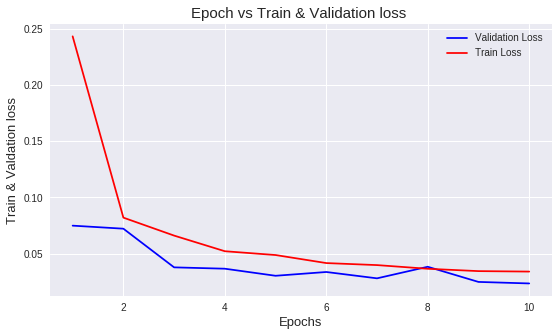

In [0]:
model = CNN1((3,3))

Even after 10 epochs both train & test loss are reducing simultaneously which infer us that, the model is still learning well.

<b> Weight distribution:

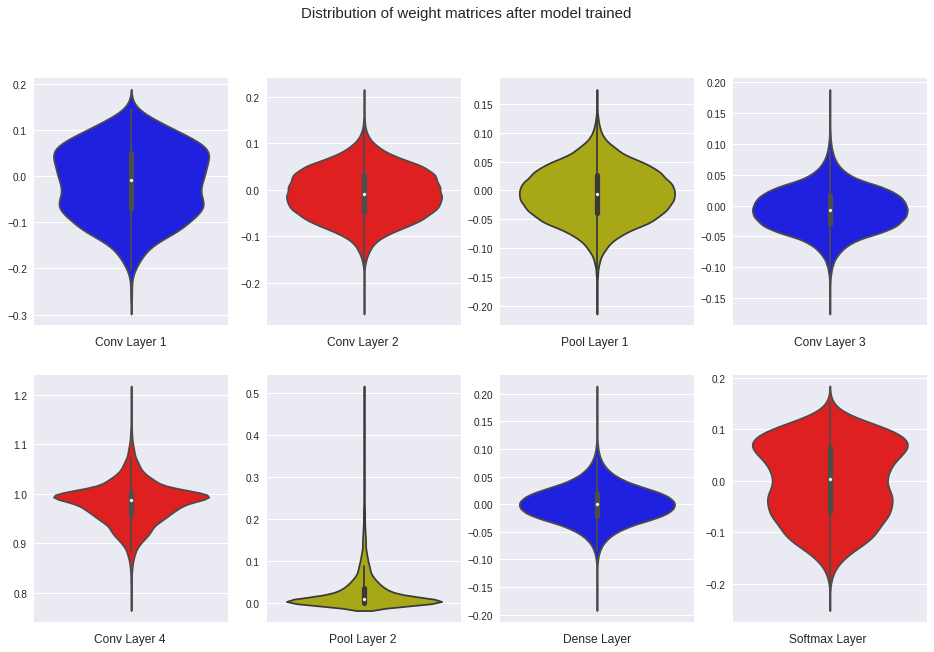

In [0]:
#Weight values
w = model.get_weights()

conv1 = w[0].flatten().reshape(-1,1)
conv2 = w[2].flatten().reshape(-1,1)
pool1 = w[4].flatten().reshape(-1,1)
  
conv3 = w[6].flatten().reshape(-1,1)
conv4 = w[8].flatten().reshape(-1,1)
pool2 = w[10].flatten().reshape(-1,1)
  
dense= w[12].flatten().reshape(-1,1)
smax = w[14].flatten().reshape(-1,1)

fig = plt.figure(figsize=(16,10))
  
plt.subplot(2, 4, 1)
sns.violinplot(y=conv1,color='b')
plt.xlabel('Conv Layer 1',fontsize=12)
  
plt.subplot(2, 4, 2)
sns.violinplot(y=conv2, color='r')
plt.xlabel('Conv Layer 2 ',fontsize=12)
  
plt.subplot(2, 4, 3)
sns.violinplot(y=pool1,color='y')
plt.xlabel('Pool Layer 1 ',fontsize=12)
  
plt.subplot(2, 4, 4)
sns.violinplot(y=conv3,color='b')
plt.xlabel('Conv Layer 3',fontsize=12)

plt.subplot(2, 4, 5)
sns.violinplot(y=conv4, color='r')
plt.xlabel('Conv Layer 4 ',fontsize=12)

plt.subplot(2, 4, 6)
sns.violinplot(y=pool2,color='y')
plt.xlabel('Pool Layer 2 ',fontsize=12)

plt.subplot(2, 4, 7)
sns.violinplot(y=dense,color='b')
plt.xlabel('Dense Layer',fontsize=12)
 
plt.subplot(2, 4, 8)
sns.violinplot(y=smax, color='r')
plt.xlabel('Softmax Layer ',fontsize=12)
  
plt.suptitle("Distribution of weight matrices after model trained",fontsize=15)
plt.show()

#### 5x5 Kernel:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_286 (Conv2D)          (None, 24, 24, 64)        1664      
_________________________________________________________________
conv2d_287 (Conv2D)          (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_288 (Dropout)        (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_288 (Conv2D)          (None, 8, 8, 128)         204928    
_________________________________________________________________
conv2d_289 (Conv2D)          (None, 8, 8, 256)         819456    
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 4, 4, 256)         0         
__________

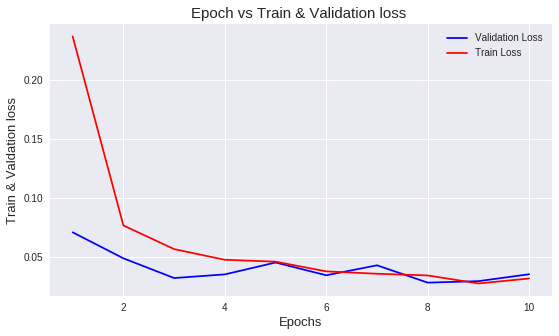

In [0]:
model=CNN1((5,5))

After 8 epochs, the model started overfitting as the test loss increased whereas train loss decreased.

<b> Weight distribution:

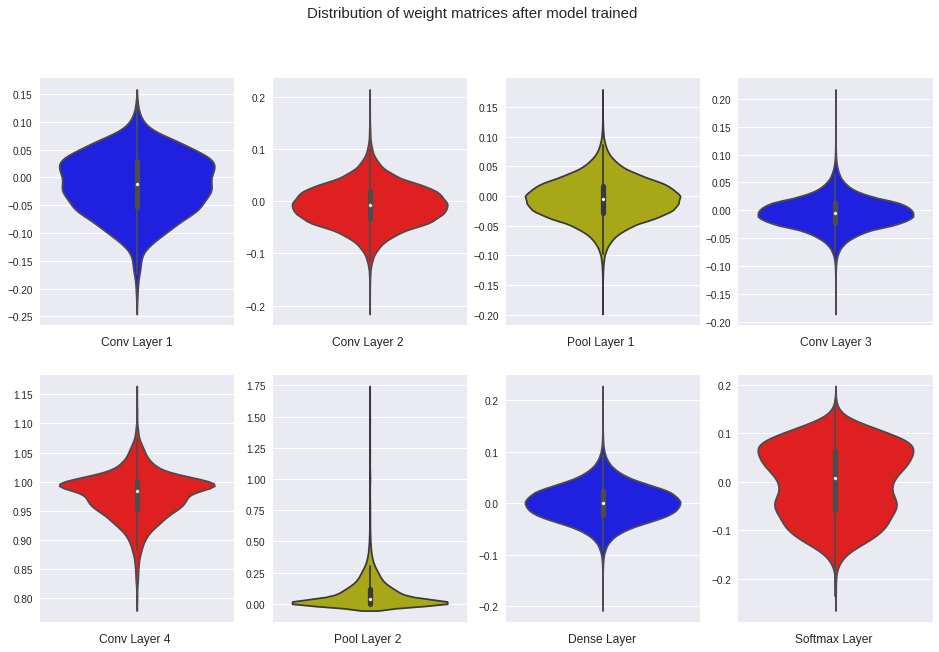

In [0]:
#Weight values
w = model.get_weights()

conv1 = w[0].flatten().reshape(-1,1)
conv2 = w[2].flatten().reshape(-1,1)
pool1 = w[4].flatten().reshape(-1,1)
  
conv3 = w[6].flatten().reshape(-1,1)
conv4 = w[8].flatten().reshape(-1,1)
pool2 = w[10].flatten().reshape(-1,1)
  
dense= w[12].flatten().reshape(-1,1)
smax = w[14].flatten().reshape(-1,1)

fig = plt.figure(figsize=(16,10))
  
plt.subplot(2, 4, 1)
sns.violinplot(y=conv1,color='b')
plt.xlabel('Conv Layer 1',fontsize=12)
  
plt.subplot(2, 4, 2)
sns.violinplot(y=conv2, color='r')
plt.xlabel('Conv Layer 2 ',fontsize=12)
  
plt.subplot(2, 4, 3)
sns.violinplot(y=pool1,color='y')
plt.xlabel('Pool Layer 1 ',fontsize=12)
  
plt.subplot(2, 4, 4)
sns.violinplot(y=conv3,color='b')
plt.xlabel('Conv Layer 3',fontsize=12)

plt.subplot(2, 4, 5)
sns.violinplot(y=conv4, color='r')
plt.xlabel('Conv Layer 4 ',fontsize=12)

plt.subplot(2, 4, 6)
sns.violinplot(y=pool2,color='y')
plt.xlabel('Pool Layer 2 ',fontsize=12)

plt.subplot(2, 4, 7)
sns.violinplot(y=dense,color='b')
plt.xlabel('Dense Layer',fontsize=12)
 
plt.subplot(2, 4, 8)
sns.violinplot(y=smax, color='r')
plt.xlabel('Softmax Layer ',fontsize=12)
  
plt.suptitle("Distribution of weight matrices after model trained",fontsize=15)
plt.show()

#### 7x7 Kernel:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_294 (Conv2D)          (None, 22, 22, 64)        3200      
_________________________________________________________________
conv2d_295 (Conv2D)          (None, 22, 22, 64)        200768    
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_294 (Dropout)        (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 5, 5, 128)         401536    
_________________________________________________________________
conv2d_297 (Conv2D)          (None, 5, 5, 256)         1605888   
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 2, 2, 256)         0         
__________

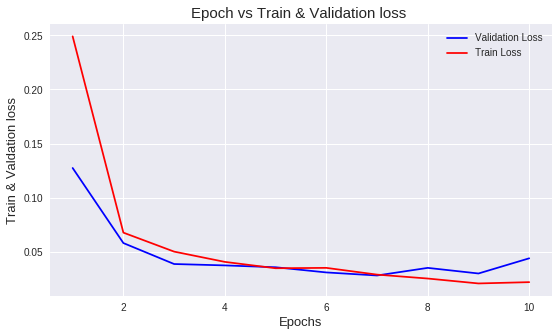

In [0]:
model1=CNN1((7,7))

Beyond 7 epochs, the model started overfitting.

<b> Weight distribution:

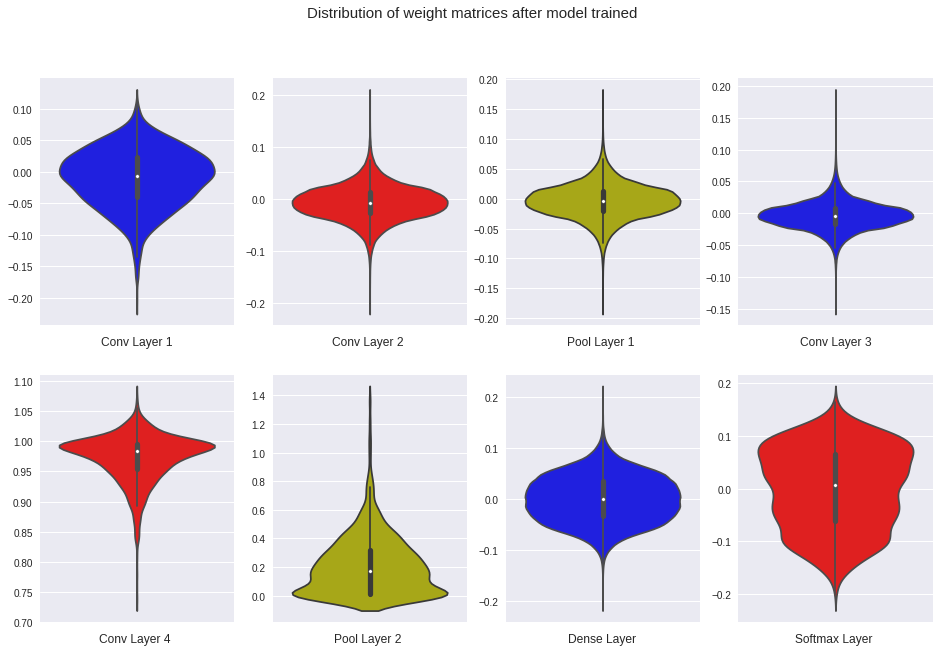

In [0]:
#Weight values
w = model1.get_weights()

conv1 = w[0].flatten().reshape(-1,1)
conv2 = w[2].flatten().reshape(-1,1)
pool1 = w[4].flatten().reshape(-1,1)
  
conv3 = w[6].flatten().reshape(-1,1)
conv4 = w[8].flatten().reshape(-1,1)
pool2 = w[10].flatten().reshape(-1,1)
  
dense= w[12].flatten().reshape(-1,1)
smax = w[14].flatten().reshape(-1,1)

fig = plt.figure(figsize=(16,10))
  
plt.subplot(2, 4, 1)
sns.violinplot(y=conv1,color='b')
plt.xlabel('Conv Layer 1',fontsize=12)
  
plt.subplot(2, 4, 2)
sns.violinplot(y=conv2, color='r')
plt.xlabel('Conv Layer 2 ',fontsize=12)
  
plt.subplot(2, 4, 3)
sns.violinplot(y=pool1,color='y')
plt.xlabel('Pool Layer 1 ',fontsize=12)
  
plt.subplot(2, 4, 4)
sns.violinplot(y=conv3,color='b')
plt.xlabel('Conv Layer 3',fontsize=12)

plt.subplot(2, 4, 5)
sns.violinplot(y=conv4, color='r')
plt.xlabel('Conv Layer 4 ',fontsize=12)

plt.subplot(2, 4, 6)
sns.violinplot(y=pool2,color='y')
plt.xlabel('Pool Layer 2 ',fontsize=12)

plt.subplot(2, 4, 7)
sns.violinplot(y=dense,color='b')
plt.xlabel('Dense Layer',fontsize=12)
 
plt.subplot(2, 4, 8)
sns.violinplot(y=smax, color='r')
plt.xlabel('Softmax Layer ',fontsize=12)
  
plt.suptitle("Distribution of weight matrices after model trained",fontsize=15)
plt.show()

### Hyperparameter Tuning:

Since we analyzed how the  CNN model's performance vary with respect to different kernel sizes used in the convolution layers , now let's find the best hyperparameter settings for this specified architecture.

In [0]:
kernel_size = [(3,3),(5,5),(7,7)]
drop=[0.1,0.3,0.5,0.7,0.9]

model = KerasClassifier(build_fn=convnet1, epochs=10, batch_size=batch_size, verbose=0)
param_grid = dict(k=kernel_size,keep_prob=drop)

grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=2,verbose=1)
grid.fit(x_train, y_train)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Instructions for updating:
Use tf.cast instead.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 44.5min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f557eaeb4e0>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'k': [(3, 3), (5, 5), (7, 7)], 'keep_prob': [0.1, 0.3, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
a=pd.DataFrame(grid.cv_results_)
a.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_k,param_keep_prob,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,81.417498,2.420801,0.985850,0.995050,"(3, 3)",0.1,"{'k': (3, 3), 'keep_prob': 0.1}",9,0.984300,0.992733,0.987400,0.997367,0.805738,0.030681,0.001550,0.002317
1,80.864417,2.521951,0.988100,0.995767,"(3, 3)",0.3,"{'k': (3, 3), 'keep_prob': 0.3}",4,0.988933,0.996200,0.987267,0.995333,0.049456,0.023721,0.000833,0.000433
2,81.206444,2.644997,0.990967,0.996117,"(3, 3)",0.5,"{'k': (3, 3), 'keep_prob': 0.5}",1,0.990667,0.995833,0.991267,0.996400,0.079490,0.017584,0.000300,0.000283
3,81.693671,2.780387,0.986717,0.990733,"(3, 3)",0.7,"{'k': (3, 3), 'keep_prob': 0.7}",7,0.987167,0.991167,0.986267,0.990300,0.034386,0.028722,0.000450,0.000433
4,82.226983,2.921548,0.865383,0.869200,"(3, 3)",0.9,"{'k': (3, 3), 'keep_prob': 0.9}",13,0.865067,0.870133,0.865700,0.868267,0.040447,0.044402,0.000317,0.000933


Now we found accuracy for different parameter values, we can get the best one by using best_hyperparameter utility function that we designed. 

In [0]:
best_hyperparameter(grid,a)

###################################################################

Best Hyperparameter settings:

 Score 0.990967 using {'k': (3, 3), 'keep_prob': 0.5}

###################################################################

The score for different parameter settings are :

 0.985850 (0.001550) with: {'k': (3, 3), 'keep_prob': 0.1}
 0.988100 (0.000833) with: {'k': (3, 3), 'keep_prob': 0.3}
 0.990967 (0.000300) with: {'k': (3, 3), 'keep_prob': 0.5}
 0.986717 (0.000450) with: {'k': (3, 3), 'keep_prob': 0.7}
 0.865383 (0.000317) with: {'k': (3, 3), 'keep_prob': 0.9}
 0.965033 (0.019700) with: {'k': (5, 5), 'keep_prob': 0.1}
 0.988767 (0.000533) with: {'k': (5, 5), 'keep_prob': 0.3}
 0.978283 (0.004383) with: {'k': (5, 5), 'keep_prob': 0.5}
 0.987700 (0.000200) with: {'k': (5, 5), 'keep_prob': 0.7}
 0.713867 (0.074200) with: {'k': (5, 5), 'keep_prob': 0.9}
 0.985767 (0.002800) with: {'k': (7, 7), 'keep_prob': 0.1}
 0.987517 (0.002450) with: {'k': (7, 7), 'keep_prob': 0.3}
 0.990017 (0.00071

The best settings of hyperparameters are , <b> Kernel size = 7 x 7 and with dropout 0.5. </b>

The lowest values of accuracies happened when Keep probablity was set to 0.9, which means the model is overfitting with train data when dropouts are not used. 

### Implementing best hyperparameter setting:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)    

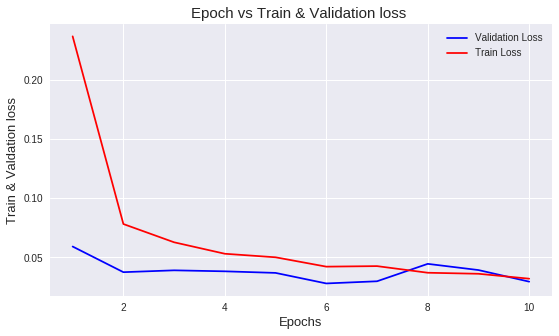

In [0]:
model=CNN1((3,3),0.5)

<b> Weight distribution:

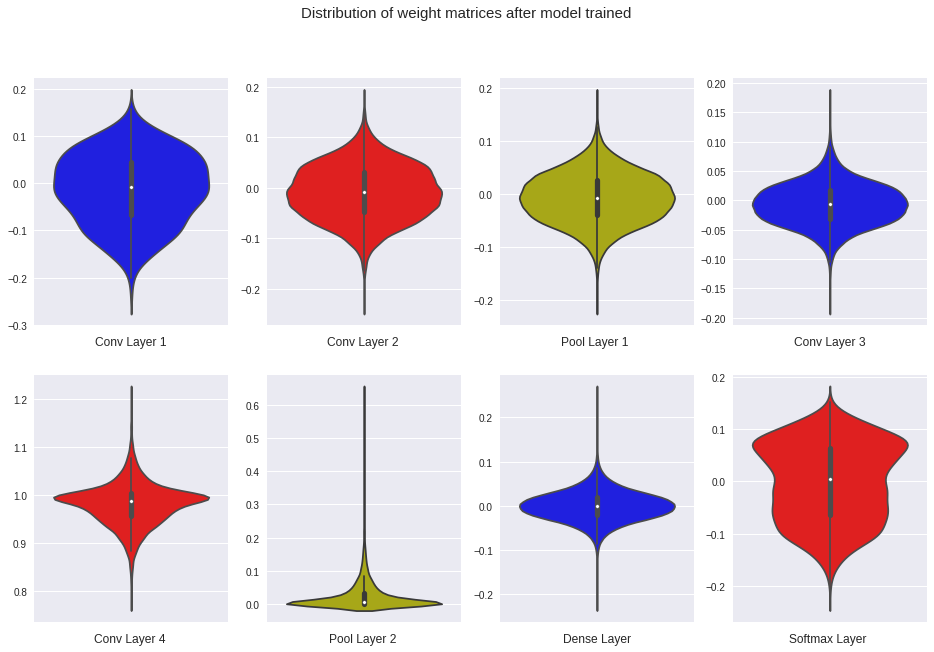

In [0]:
#Weight values
w = model.get_weights()

conv1 = w[0].flatten().reshape(-1,1)
conv2 = w[2].flatten().reshape(-1,1)
pool1 = w[4].flatten().reshape(-1,1)
  
conv3 = w[6].flatten().reshape(-1,1)
conv4 = w[8].flatten().reshape(-1,1)
pool2 = w[10].flatten().reshape(-1,1)
  
dense= w[12].flatten().reshape(-1,1)
smax = w[14].flatten().reshape(-1,1)

fig = plt.figure(figsize=(16,10))
  
plt.subplot(2, 4, 1)
sns.violinplot(y=conv1,color='b')
plt.xlabel('Conv Layer 1',fontsize=12)
  
plt.subplot(2, 4, 2)
sns.violinplot(y=conv2, color='r')
plt.xlabel('Conv Layer 2 ',fontsize=12)
  
plt.subplot(2, 4, 3)
sns.violinplot(y=pool1,color='y')
plt.xlabel('Pool Layer 1 ',fontsize=12)
  
plt.subplot(2, 4, 4)
sns.violinplot(y=conv3,color='b')
plt.xlabel('Conv Layer 3',fontsize=12)

plt.subplot(2, 4, 5)
sns.violinplot(y=conv4, color='r')
plt.xlabel('Conv Layer 4 ',fontsize=12)

plt.subplot(2, 4, 6)
sns.violinplot(y=pool2,color='y')
plt.xlabel('Pool Layer 2 ',fontsize=12)

plt.subplot(2, 4, 7)
sns.violinplot(y=dense,color='b')
plt.xlabel('Dense Layer',fontsize=12)
 
plt.subplot(2, 4, 8)
sns.violinplot(y=smax, color='r')
plt.xlabel('Softmax Layer ',fontsize=12)
  
plt.suptitle("Distribution of weight matrices after model trained",fontsize=15)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 256)         0         
__________

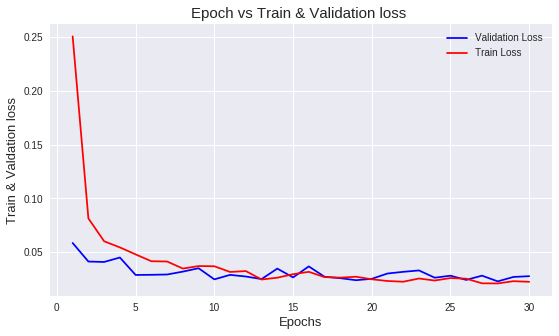

In [0]:
epoch=25
model=CNN1((3,3),0.5)

From somewhere between 18 epochs, the model is performing well, after 18 epochs, the test loss seem to be fluctuating and no much decrease in value, which can cause the model to overfit.

# <center> Architecture 2 

The architecture has, 

* 3 Convolution layers.

* 2 Max pooling layer.

* 2 FC layers.

<b> Input -> Convnet(64) -> Convnet(64) -> Maxpool -> Convnet(128) -> Maxpool -> Dense(1024) -> Dense(512) -> Softmax(10) </b>


In the architecture 1, we didn't initialized weight vectors manually. But in this case, we will select appropriate initialization strategy as per activation function used.

In [0]:
def convnet2(k,keep_prob=0.5):
  
  '''
  To create a convnet model with repect to the specified kernel size
  '''
  weight_init=he_normal(seed=33) # Since we will use ReLU activation.
  model = Sequential()
  model.add(Conv2D(64, kernel_size=k,activation='relu',input_shape=input_shape,kernel_initializer=weight_init))
  model.add(Conv2D(64, kernel_size=k, activation='relu',padding='same',kernel_initializer=weight_init))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(keep_prob))
  
  model.add(Conv2D(128, kernel_size=k,activation='relu',padding='same',kernel_initializer=weight_init))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(keep_prob))
  
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu',kernel_initializer=weight_init))
  model.add(Dropout(keep_prob))
  
  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu',kernel_initializer=weight_init))
  model.add(Dropout(keep_prob))
  
  model.add(Dense(num_op_classes, activation='softmax',kernel_initializer=glorot_normal(seed=33)))

  #Compiling the created architecture
  model.compile(loss=categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
  model.summary()
  return model

In [0]:
def CNN2(k_size,keep_prob=0.5):
  '''
  
  '''
  model=convnet2(k_size,keep_prob)
  final_model=model.fit(x_tr, y_tr,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_cv, y_cv))

  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  score = model.evaluate(x_tr, y_tr, verbose=0)
  print('Train loss:', score[0])
  print('Train accuracy:', score[1])

  x=range(1,epochs+1)
  validation_loss=final_model.history['val_loss']
  train_loss=final_model.history['loss']

  plotter(x, validation_loss, train_loss)
  return model



Since in the architecture 1, we analysed, how the model performance is impacted with respect to kernel size and so on, we will directly move on to selecting best hyperparameter values.

### Hyperparameter Tuning:

In [0]:
hyperparameter_tuning(convnet2)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 40.9min finished


###################################################################

Best Hyperparameter settings:

 Score 0.990300 using {'k': (5, 5), 'keep_prob': 0.3}

###################################################################

The score for different parameter settings are :

 0.983683 (0.000717) with: {'k': (3, 3), 'keep_prob': 0.1}
 0.989900 (0.000167) with: {'k': (3, 3), 'keep_prob': 0.3}
 0.984817 (0.003550) with: {'k': (3, 3), 'keep_prob': 0.5}
 0.959850 (0.002883) with: {'k': (3, 3), 'keep_prob': 0.7}
 0.563300 (0.029167) with: {'k': (3, 3), 'keep_prob': 0.9}
 0.987983 (0.000817) with: {'k': (5, 5), 'keep_prob': 0.1}
 0.990300 (0.000967) with: {'k': (5, 5), 'keep_prob': 0.3}
 0.987217 (0.000283) with: {'k': (5, 5), 'keep_prob': 0.5}
 0.964817 (0.001817) with: {'k': (5, 5), 'keep_prob': 0.7}
 0.534350 (0.015183) with: {'k': (5, 5), 'keep_prob': 0.9}
 0.986583 (0.000550) with: {'k': (7, 7), 'keep_prob': 0.1}
 0.987967 (0.000033) with: {'k': (7, 7), 'keep_prob': 0.3}
 0.990283 (0.00001

Architecture 2 works well on 5x5 kernel along with dropout rate of 0.5

### Implementing best hyperparameter setting:

Train on 51000 samples, validate on 9000 samples
Epoch 1/10
51000/51000 [==============================] - 14s 273us/step - loss: 0.1935 - acc: 0.9422 - val_loss: 0.0623 - val_acc: 0.9828
Epoch 2/10
51000/51000 [==============================] - 12s 237us/step - loss: 0.0648 - acc: 0.9806 - val_loss: 0.0689 - val_acc: 0.9820
Epoch 3/10
51000/51000 [==============================] - 12s 237us/step - loss: 0.0487 - acc: 0.9856 - val_loss: 0.0550 - val_acc: 0.9836
Epoch 4/10
51000/51000 [==============================] - 12s 237us/step - loss: 0.0353 - acc: 0.9888 - val_loss: 0.0325 - val_acc: 0.9903
Epoch 5/10
51000/51000 [==============================] - 12s 237us/step - loss: 0.0308 - acc: 0.9905 - val_loss: 0.0466 - val_acc: 0.9880
Epoch 6/10
51000/51000 [==============================] - 12s 237us/step - loss: 0.0286 - acc: 0.9912 - val_loss: 0.0355 - val_acc: 0.9907
Epoch 7/10
51000/51000 [==============================] - 12s 236us/step - loss: 0.0291 - acc: 0.9912 - val_loss: 0.0

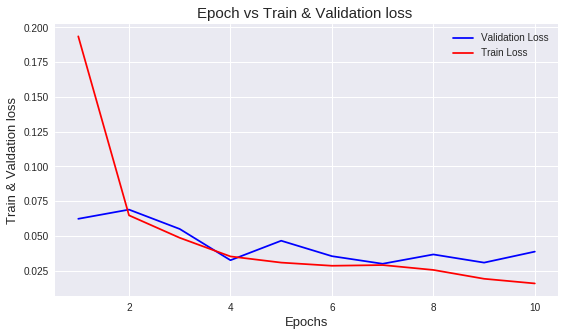

In [0]:
model = CNN2((5,5),0.3)

7 epochs seem to be the best case for the architecture 2.

<b> Weight distribution:

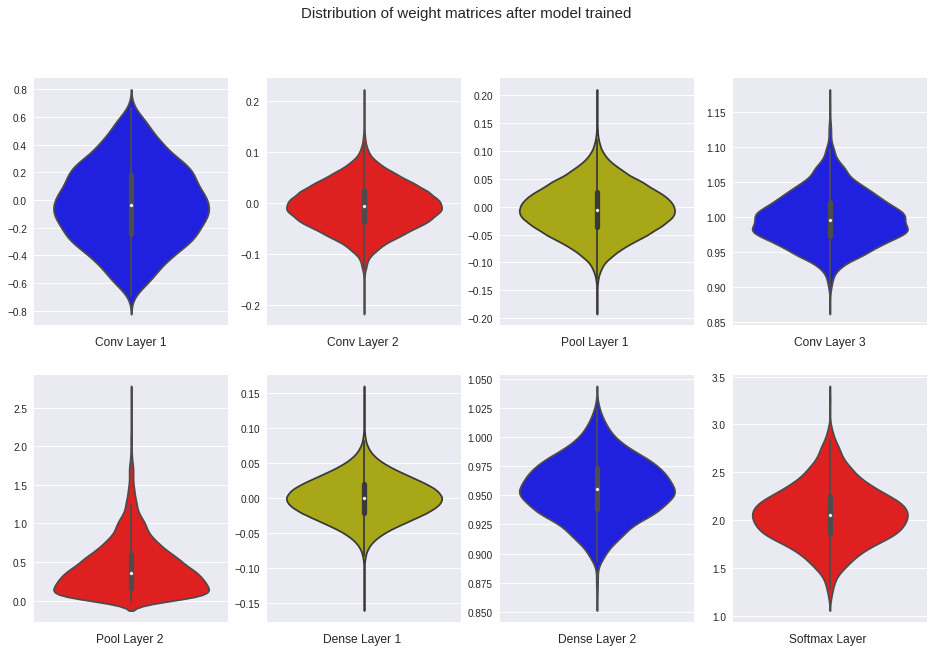

In [0]:
#Weight values
w = model.get_weights()

conv1 = w[0].flatten().reshape(-1,1)
conv2 = w[2].flatten().reshape(-1,1)
pool1 = w[4].flatten().reshape(-1,1)
  
conv3 = w[6].flatten().reshape(-1,1)
conv4 = w[8].flatten().reshape(-1,1)
pool2 = w[10].flatten().reshape(-1,1)
  
dense= w[12].flatten().reshape(-1,1)
smax = w[14].flatten().reshape(-1,1)

fig = plt.figure(figsize=(16,10))
  
plt.subplot(2, 4, 1)
sns.violinplot(y=conv1,color='b')
plt.xlabel('Conv Layer 1',fontsize=12)
  
plt.subplot(2, 4, 2)
sns.violinplot(y=conv2, color='r')
plt.xlabel('Conv Layer 2 ',fontsize=12)
  
plt.subplot(2, 4, 3)
sns.violinplot(y=pool1,color='y')
plt.xlabel('Pool Layer 1 ',fontsize=12)
  
plt.subplot(2, 4, 4)
sns.violinplot(y=conv3,color='b')
plt.xlabel('Conv Layer 3',fontsize=12)

plt.subplot(2, 4, 5)
sns.violinplot(y=conv4, color='r')
plt.xlabel('Pool Layer 2 ',fontsize=12)

plt.subplot(2, 4, 6)
sns.violinplot(y=pool2,color='y')
plt.xlabel('Dense Layer 1 ',fontsize=12)

plt.subplot(2, 4, 7)
sns.violinplot(y=dense,color='b')
plt.xlabel('Dense Layer 2',fontsize=12)
 
plt.subplot(2, 4, 8)
sns.violinplot(y=smax, color='r')
plt.xlabel('Softmax Layer ',fontsize=12)
  
plt.suptitle("Distribution of weight matrices after model trained",fontsize=15)
plt.show()

Let us increase the number of epochs and see if we can find optimal number of epochs to be trained, by visualizing the loss vs epoch plot.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 12, 12, 128)       204928    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 6, 6, 128)         0         
__________

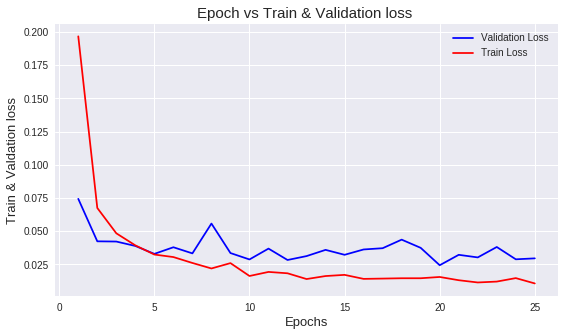

In [0]:
epochs=25
model = CNN2((5,5),0.3)

20 epochs seems to be the best value for this architecture.

# <center> Architecture 3

The 3rd architecture was designed a bit deeper which has, 

* 6 Convolution layers.

* 3 Max pooling layer.

* 2 Dense layers.

<b> Input -> Convnet(64) -> Convnet(64) -> Maxpool -> Convnet(100) -> Convnet(100) -> Maxpool -> Convnet(128) -> Convnet(128)  -> Maxpool -> Dense(1024) -> Dense(512) -> Softmax(10) </b>


In [0]:
def convnet3(k,keep_prob=0.5):
  
  '''
  To create a convnet model with repect to the specified kernel size
  '''
  weight_init=he_normal(seed=33)
  model = Sequential()
  
  model.add(Conv2D(64, kernel_size=k,activation='relu',input_shape=input_shape,kernel_initializer=weight_init))
  model.add(Conv2D(64, kernel_size=k, activation='relu',padding='same',kernel_initializer=weight_init))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(keep_prob))
  
  model.add(Conv2D(100, kernel_size=k, activation='relu',kernel_initializer=weight_init))
  model.add(Conv2D(100, kernel_size=k, activation='relu',padding='same',kernel_initializer=weight_init))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(keep_prob))
  
  model.add(Conv2D(128, kernel_size=k, activation='relu',padding='same',kernel_initializer=weight_init))
  model.add(Conv2D(128, kernel_size=k, activation='relu',padding='same',kernel_initializer=weight_init))
  model.add(MaxPooling2D(pool_size=(1, 1)))
  model.add(Dropout(keep_prob))
  
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu',kernel_initializer=weight_init))
  model.add(Dropout(keep_prob))
  
  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu',kernel_initializer=weight_init))
  model.add(Dropout(keep_prob))
  
  model.add(Dense(num_op_classes, activation='softmax',kernel_initializer=glorot_normal(seed=33)))

  #Compiling the created architecture
  model.compile(loss=categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
  model.summary()
  return model

In [0]:
def CNN3(k_size,keep_prob=0.5):
  '''
  
  '''
  model=convnet3(k_size,keep_prob)
  final_model=model.fit(x_tr, y_tr,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_cv, y_cv))

  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  score = model.evaluate(x_tr, y_tr, verbose=0)
  print('Train loss:', score[0])
  print('Train accuracy:', score[1])

  x=range(1,epochs+1)
  validation_loss=final_model.history['val_loss']
  train_loss=final_model.history['loss']

  plotter(x, validation_loss, train_loss)
  return model



### Hyperparameter Tuning:

In [0]:
hyperparameter_tuning(convnet3)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 58.4min finished


###################################################################

Best Hyperparameter settings:

 Score 0.987617 using {'k': (7, 7), 'keep_prob': 0.3}

###################################################################

The score for different parameter settings are :

 0.983017 (0.004250) with: {'k': (3, 3), 'keep_prob': 0.1}
 0.981267 (0.003000) with: {'k': (3, 3), 'keep_prob': 0.3}
 0.978900 (0.002167) with: {'k': (3, 3), 'keep_prob': 0.5}
 0.888233 (0.035033) with: {'k': (3, 3), 'keep_prob': 0.7}
 0.112367 (0.001733) with: {'k': (3, 3), 'keep_prob': 0.9}
 0.985550 (0.000717) with: {'k': (5, 5), 'keep_prob': 0.1}
 0.985917 (0.003450) with: {'k': (5, 5), 'keep_prob': 0.3}
 0.938633 (0.017967) with: {'k': (5, 5), 'keep_prob': 0.5}
 0.966867 (0.009567) with: {'k': (5, 5), 'keep_prob': 0.7}
 0.112417 (0.001717) with: {'k': (5, 5), 'keep_prob': 0.9}
 0.985300 (0.002533) with: {'k': (7, 7), 'keep_prob': 0.1}
 0.987617 (0.001783) with: {'k': (7, 7), 'keep_prob': 0.3}
 0.987317 (0.00088

The optimal parameter values are <b> kernel size = (7,x7) and the keep_prob rate is  0.3

### Implementing best hyperparameter setting:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 64)        3200      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        200768    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 100)         313700    
_________________________________________________________________
conv2d_4 (Conv2D)    

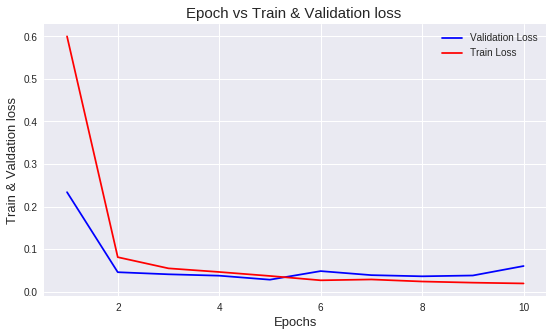

In [0]:
model=CNN3((7,7),0.3)

Since the network is deep, the model started overfitting after 5 epochs which is evident from the above plot.

<b> Weight distribution:

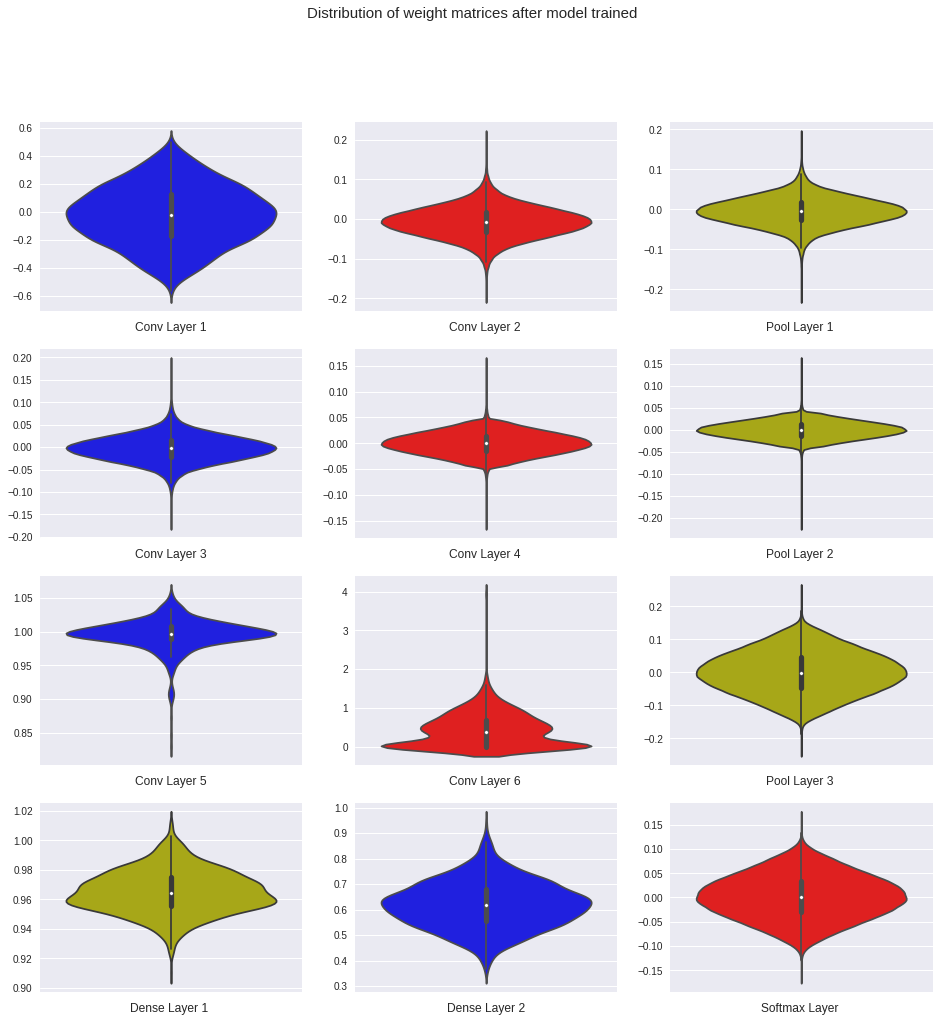

In [0]:
#Weight values
w = model.get_weights()

conv1 = w[0].flatten().reshape(-1,1)
conv2 = w[2].flatten().reshape(-1,1)
pool1 = w[4].flatten().reshape(-1,1)
  
conv3 = w[6].flatten().reshape(-1,1)
conv4 = w[8].flatten().reshape(-1,1)
pool2 = w[10].flatten().reshape(-1,1)

conv5 = w[12].flatten().reshape(-1,1)
conv6 = w[14].flatten().reshape(-1,1)
pool3 = w[16].flatten().reshape(-1,1)
  
dense1= w[18].flatten().reshape(-1,1)
dense2= w[20].flatten().reshape(-1,1)
smax = w[22].flatten().reshape(-1,1)

fig = plt.figure(figsize=(16,16))
  
plt.subplot(4, 3, 1)
sns.violinplot(y=conv1,color='b')
plt.xlabel('Conv Layer 1',fontsize=12)
  
plt.subplot(4, 3, 2)
sns.violinplot(y=conv2, color='r')
plt.xlabel('Conv Layer 2 ',fontsize=12)
  
plt.subplot(4, 3, 3)
sns.violinplot(y=pool1,color='y')
plt.xlabel('Pool Layer 1 ',fontsize=12)
  
plt.subplot(4, 3, 4)
sns.violinplot(y=conv3,color='b')
plt.xlabel('Conv Layer 3',fontsize=12)

plt.subplot(4, 3, 5)
sns.violinplot(y=conv4, color='r')
plt.xlabel('Conv Layer 4 ',fontsize=12)

plt.subplot(4, 3, 6)
sns.violinplot(y=pool2,color='y')
plt.xlabel('Pool Layer 2 ',fontsize=12)

plt.subplot(4, 3, 7)
sns.violinplot(y=conv5,color='b')
plt.xlabel('Conv Layer 5',fontsize=12)
  
plt.subplot(4, 3, 8)
sns.violinplot(y=conv6, color='r')
plt.xlabel('Conv Layer 6 ',fontsize=12)
  
plt.subplot(4, 3, 9)
sns.violinplot(y=pool3,color='y')
plt.xlabel('Pool Layer 3 ',fontsize=12)

plt.subplot(4, 3, 10)
sns.violinplot(y=dense1,color='y')
plt.xlabel('Dense Layer 1 ',fontsize=12)

plt.subplot(4, 3, 11)
sns.violinplot(y=dense2,color='b')
plt.xlabel('Dense Layer 2',fontsize=12)
 
plt.subplot(4, 3, 12)
sns.violinplot(y=smax, color='r')
plt.xlabel('Softmax Layer ',fontsize=12)
  
plt.suptitle("Distribution of weight matrices after model trained",fontsize=15)
plt.show()

## <center> Performance comparision

Below, We will analyse the performance of the best parameter settings for the above 3 architectures respectively.

In [2]:
print('\n All 3 architectures are trained for 10 Epochs \n')
tmp=pd.DataFrame(columns=['Architecture','Depth','# Conv layers','# Maxpool layers','# FC layers','Kernel size','Dropout','Train accuracy','Test accuracy'])

#2Layers 
#SGD
tmp.loc[0]=[1,7,4,2,1,'(3x3)',0.5,0.9965,0.9933]
tmp.loc[1]=[2,7,3,2,2,'(5x5)',0.3,0.9972,0.9926]
tmp.loc[2]=[3,11,6,3,2,'(7x7)',0.3,0.9942,0.9881]

tmp



 All 3 architectures are trained for 10 Epochs 



,Architecture,Depth,# Conv layers,# Maxpool layers,# FC layers,Kernel size,Dropout,Train accuracy,Test accuracy
0,1,7,4,2,1,(3x3),0.5,0.9965,0.9933
1,2,7,3,2,2,(5x5),0.3,0.9972,0.9926
2,3,11,6,3,2,(7x7),0.3,0.9942,0.9881


### <i> Architecture 1 along with 3x3 kernel and 0.5 as dropout rate is the best performing model among the three listed in this notebook.

## <center> Conclusion

* Though the design was deeper in the architecture 3, there is no significant increase in performance of the model. Such situations are explained in Resnet paper, where adding residual values from previous stages can result in better performance. since this notebook is for learning about CNN, I din't took it up further.

* If we notice the dropout rate, it is clearly evident that, as the number of layers & no of neurons used in them increases, keep probablity rate decreases which emphasize that the model seem to overfit when we have deeper networks.

* By analyzing architecture 1 with different kernel size,we can say that it is a hyperparameter to be tuned and there is no linear relationship between size of kernel and performance of the model. and so it varies as per architecture.

* From the weight distributions plot for all architectures, it is evident that the model doesn't suffer much with the gradient problems like Vanishing/Exploding grad problems because we've chosen better weight initialization strategy.